## Travel Agent

AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input

search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation


search weather forcasting
1. get current weather
2. get weather forcast


search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range


calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
  

currency_converion
1. get exchnage rate
2. convert currancy
  

Itinery generation
1. get day plan
2. crete full itinery


create Trip Summary
  

Retun complete traval plan


In [56]:
import os
from dotenv import load_dotenv
load_dotenv()
import operator
from typing import Annotated, Sequence, List,Optional
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import tool
import requests
from langchain_community.utilities import GoogleSerperAPIWrapper, GooglePlacesAPIWrapper
from langchain_community.tools import  DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
## openai chat model
llm_openai = ChatOpenAI(model='o3-mini')

In [3]:
llm_openai.invoke('Hi')

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 7, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BjLG3Df3B0a0JmeZKdyWbjLkPVgSP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--802a0815-0ac5-40e3-92e7-ce69c6acefc9-0', usage_metadata={'input_tokens': 7, 'output_tokens': 87, 'total_tokens': 94, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}})

In [ ]:
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun


In [24]:
import time
def get_search_results(user_query: str) -> str:
    '''
    This tool will use DuckDuckGo to search for 
    tourist attractions, restaurants, activities, and transportation based on user query.
    
    Args:
        user_query (str): The user's query for searching tourist attractions, restaurants, activities, and transportation.
        
    Returns:
        str: A string containing the search results formatted as a list of tourist attractions, restaurants, activities, and transportation options.
    '''
    search = DuckDuckGoSearchRun()
    
    queries = {
        "Attractions": 'Top 3 tourist attraction in {user_query}',
        "Restaurants": 'Top 3 restaurants in {user_query}',
        "Activities": 'Top 3 activities in {user_query}',
        "Transport" : 'Means of transport in {user_query}'
    }
    results = {}
    
    for key, query in queries.items():
        try:
            results[key] = search.invoke(query)
            time.sleep(5)
        except Exception as e:
            print(f'Error {str(e)}')
        
    return results


In [28]:
get_search_results('Paris, France')

{'Attractions': 'Around 3.8 million people visit every year, making it Austria\'s top tourist spot. Walk through grand rooms once used by emperors. The palace oozes royal history—golden halls, manicured gardens, and classic art everywhere you look. The park around the palace is massive. There\'s even a zoo and some gorgeous fountains. Visitors have decided These are the 9 best museums in Germany New top ranking The 10 best ice cream parlors in Germany According to "Time Out" Hong Kong Is the City with the Best Public Transporta in the World 3rd place: Angkor Wat, Cambodia. The Angkor Wat temple complex in Siem Reap, Cambodia, ranks third in Tripadvisor\'s rankings of the world\'s most popular attractions. Global tourism weaves together history, culture, and modern entertainment in ways that captivate millions each year. In this guide, we reveal 21 of the most visited tourist attractions in the world, spanning massive malls, ancient wonders, bustling city squares, and legendary theme pa

In [92]:
import time
@tool 
def search_result(query:str) -> str:
    '''
    Search results using DuckDuckGoSearch
    
    Args:
        query (str): The user's query for searching tourist attractions, restaurants, activities, and transportation.
        
    Returns:
        str: A string containing the search results formatted as a list of tourist attractions, restaurants, activities, and transportation options.
    '''
    
    search = DuckDuckGoSearchRun()
    result = search.invoke(query)
    return(f'ToolCall : {result}')
    time.sleep(5)
    
    return result

In [ ]:

#search = DuckDuckGoSearchRun()
weather = OpenWeatherMapAPIWrapper()
tavily_tool = TavilySearchResults(max_results=3)
llm_openai = ChatOpenAI(model='o3-mini')
llm_with_tool = llm_openai.bind_tools([tavily_tool, weather.run])

In [ ]:
SYSTEM_PROMPT = SystemMessage(
    content = '''You are a helpful travel agent and your task is to find following information in a city based on user queries:
        Use TavilyTool Search to find:
        1. top 2 tourist attractions
        2. top 2 restaurants
        3. top 2 activities 
        4. means of transportation for the city mentioned in user query
        
        Use OpenWeatherMap to find (if travel date is provided use that else user current date):
        5. current weather and weather forcast for the city mentioned in user query.
        '''
)

def function_tool(state:MessagesState):
    
    user_question = state['messages']
    
    input_question = [SYSTEM_PROMPT] + user_question
    
    response = llm_with_tool.invoke(input_question)
    print(response)
    
    return {'messages': [response]}

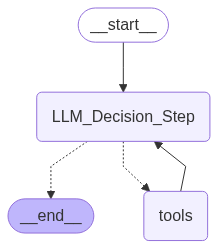

In [103]:
import sys
builder = StateGraph(MessagesState)
builder.add_node('LLM_Decision_Step',function_tool)
builder.add_node('tools', ToolNode([tavily_tool, weather.run]))
builder.add_edge(START,'LLM_Decision_Step')
builder.add_conditional_edges(
    'LLM_Decision_Step',
    tools_condition
)
builder.add_edge('tools','LLM_Decision_Step')
app = builder.compile()
app

In [ ]:
message = [HumanMessage(content = 'Kelowna, Canada')]
app.invoke({'messages':message})

In [ ]:

search_google_serp = GoogleSerperAPIWrapper()
search_duckduck = DuckDuckGoSearchRun()


In [ ]:
import pprint
res = search_duckduck.invoke('means of transport option to travel around in Kelowna, canada like bus, taxi, renting a car etc ')
pprint.pp(res)

In [ ]:
import pprint
result = search_google_serp.run('means of transport option to travel around in Kelowna, canada like bus, taxi, renting a car etc')
print(len(list(result)))
pprint.pp(result)


In [130]:
search_google_serp.run('Mid range hotels in Paris. Name of hotel and current price per night booking availability')

"View deals from $97 per night, see photos and read reviews for the best Paris hotels from travelers like you - then compare today's prices ... Looking for Paris Hotel? 2-star hotels from $41, 3 stars from $41 and 4 stars+ from $122. Stay at Hotel Ferney République from $103/night, ibis budget ... Paris – 13 hotels and places to stay · Fairfield by Marriott Inn & Suites Paris · Vip inn and suites · Hampton Inn Paris · Home2 Suites By Hilton Paris · Paris Inn & ... Centrally located in Paris, Hotel Paradis is perfect for single or couples. The rates are anywhere between $120-$180 depending on the room size. Budget-conscious travelers will find plenty of affordable options, including hostels and budget hotels in Paris. The Ibis Paris Tour Eiffel Cambronne 15Eme is ... Find 3 Star Hotels in Paris from $69 · Check availability on Paris 3 Star Hotels · Compare Paris 3 Star Hotels with updated room rates, reviews, and availability. These are our favorite reasonably priced, smart hotels in Pa

In [131]:
search_duckduck.invoke('Mid range hotels in Paris. Name of hotel and current price per night booking availability')

"Mid-Range Luxe Prices: While the prices of hotels change rapidly, expect these hotels to range from $225 to $349 per night for the standard rooms in these hotels and more for the high-end suites. That will obviously vary, so click the link which will take you to Booking.com to see current prices. Tucked just a block back from the Seine and a few minutes' walk from Notre Dame, this luxurious, cedar-scented 109-room hotel — which earned a spot on the T+L It List in 2023 — is in a class ... If you are traveling as a group of two, a double room in a 2-star hotel will cost between €50 and €175. For the mid-range traveler, on average you will pay between €150 and €300 per night for a double room. 4-star hotels typically range from €300 to €600 per night, and the 5-star hotels usually start around €500 and go up from here. Travelers can expect affordable hotel prices to range between $30 and $100 per night, depending on location, amenities, and booking time. Price Segmentation: - Hostels: $3

### Check_Weather Class to get current weather forcast.

In [124]:

class Check_Weather:
    def __init__(self,api_key: str):
        self.api_key = api_key
        self.base_url = 'https://api.openweathermap.org/data/2.5'
        
    def get_weather(self, city: str) -> str:
        ''' Get the current weather for a given city.'''
        try:
            self.url = f'{self.base_url}/weather?q={city}&units=metric&appid={self.api_key}'
            response = requests.get(self.url)
            return response.__dict__
        except Exception as e:
            print(f'Error: {str(e)}')
            return {}
        
    def get_forecast(self, city: str, days:int) -> str:
        ''' Get the weather forecast for a given city.'''
        try:
            cnt = days * 8  # OpenWeatherMap API returns 8 forecasts per day
            self.url = f'{self.base_url}/forecast?q={city}&cnt={days}&units=metric&appid={self.api_key}'
            
            response = requests.get(self.url)
            return response.json()
        except Exception as e:
            print(f'Error: {str(e)}')
            return {}
    

In [125]:
weather_api_key = os.getenv('OPENWEATHERMAP_API_KEY')
weather = Check_Weather(api_key = weather_api_key)


In [126]:
result = weather.get_weather('Kelowna, Canada')
result

{'_content': b'{"coord":{"lon":-119.4857,"lat":49.8831},"weather":[{"id":804,"main":"Clouds","description":"overcast clouds","icon":"04n"}],"base":"stations","main":{"temp":15.49,"feels_like":14.53,"temp_min":15.49,"temp_max":15.49,"pressure":1006,"humidity":55,"sea_level":1006,"grnd_level":897},"visibility":10000,"wind":{"speed":1.03,"deg":0},"clouds":{"all":100},"dt":1750400324,"sys":{"type":1,"id":852,"country":"CA","sunrise":1750333737,"sunset":1750392588},"timezone":-25200,"id":5990579,"name":"Kelowna","cod":200}',
 '_content_consumed': True,
 '_next': None,
 'status_code': 200,
 'headers': {'Server': 'openresty', 'Date': 'Fri, 20 Jun 2025 06:21:15 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '508', 'Connection': 'keep-alive', 'X-Cache-Key': '/data/2.5/weather?q=kelowna,%20canada&units=metric', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Methods': 'GET, POST'},
 'raw': <urllib3.response.HTTPRes

In [ ]:
res = weather.get_forecast('Kelowna')
res

In [ ]:
for i in res['list']:
    print(f'{i['dt_txt']} :  {i['main']['temp']}°C,{i['weather'][0]['description']}')
    print(f"Date: {i['dt_txt']}, Temp: {i['main']['temp']}°C, Weather: {i['weather'][0]['description']}")

## Currency Convertion using https://frankfurter.dev/

In [9]:

class Currency_Converter:
    
    def __init__(self):
        self.base_url = 'https://api.frankfurter.dev/v1/latest'
        
    def convert_currency(self, from_currency: str, to_currency: str, amount:float) -> float:
        ''' Convert currency from one to another.'''
        try:
            url = f'{self.base_url}?amount={amount}&from={from_currency}&to={to_currency}'
            response = requests.get(url)
            result = response.json()
            return result['rates'][to_currency]
        except Exception as e:
            print(f'Error: {str(e)}')
            return None
        

In [10]:
converter = Currency_Converter()
converter.convert_currency('CAD','INR', 500)

31636

## Calculator for expense calculations

In [61]:
class Calculator:
    
    @staticmethod
    def add(a: float, b:float) -> float:
        '''
        Add two numbers.
        
        Args:
            a (float): First number.
            b (float): Second number.
        Returns:
            float: Sum of a and b.
        '''
        return a + b
    
    @staticmethod
    def multiply(a: float, b:float) -> float:
        '''
        Multiply two numbers.
        
        Args:
            a (float): First number.
            b (float): Second number.
        Returns:
            float: Product of a and b.
        '''
        return a * b
    
    
    @staticmethod
    def calculate_daily_budget(total_cost: float, days: int) -> float:
        '''
        Calculate the daily budget based on total cost and number of days.
        Args:
            total_cost (float): Total cost of the trip.
            days (int): Number of days for the trip.
        Returns:
            float: Daily budget for the trip.
        '''
        return total_cost / days if days > 0 else 0
    

## Configs

In [82]:
class Config:
    
    def __init__(self):
        self.weather_api_key = os.getenv('OPENWEATHERMAP_API_KEY')
        self.serper_api_key = os.getenv('SERPER_API_KEY')
        self.tavily_api_key = os.getenv('TAVILY_API_KEY')
        self.openai_api_key = os.getenv('OPENAI_API_KEY')
    
    def get_api_keys(self):
        return {
            'weather_api_key': self.weather_api_key,
            'serper_api_key': self.serper_api_key,
            'tavily_api_key': self.tavily_api_key,
            'openai_api_key': self.openai_api_key
        }


## Travel Search

In [ ]:
class Travel_Planner_Tools:
    
    def __init__(self, config: dict):
        self.config = config
        self.weather_service = Check_Weather(api_key=self.config.get('weather_api_key'))
        self.currency_converter  = Currency_Converter()
        self.calculator = Calculator()
        
        ## Initializing search tools
        self.duckduck_search = DuckDuckGoSearchRun()
        
        try:
            self.serp_search = GoogleSerperAPIWrapper(serper_api_key=self.config.get('serper_api_key'))
        except Exception as e:
            print(f'Error initializing GoogleSerperAPIWrapper: {str(e)}')
            self.serp_search = None
        
        try:
            self.tavily_search = TavilySearchResults(max_results=5, tavily_api_key=self.config.get('tavily_api_key'))
        except Exception as e:
            print(f'Error initializing TavilySearchResults: {str(e)}')
            self.tavily_search = None
            
        ## Initializing llm
        try:
            self.llm = ChatOpenAI(model = 'o3-mini', openai_api_key = self.config.get('openai_api_key'))
        except Exception as e:
            print(f'Error initializing ChatOpenAI: {str(e)}')
            self.llm = None
        
        self.tools = self._travel_planning_tools()
        if self.llm:
            self.llm_with_tools = self.llm.bind_tools(self.tools)
        

        
        ## Initializing tools
    def _travel_planning_tools(self) -> List:
        '''
        Initialize and return the list of tools for travel planning.
        Returns:
            List: List of tools for travel planning.
        '''
        ## Defining Pydantic model or structured input to get_day_plan tool
        class DayPlanItem(BaseModel):
            time: str = Field(...,description='Estimated time of the activity (e.g.,9:00 AM - 11:00 AM).')
            activity: str = Field(..., description = 'Description of the activity (e.g., Visit Eiffel Tower, Lunch at Le Comptoir).')
            location: Optional[str] = Field(None, description= 'Specific location or address of the activity.')
            notes: Optional[str] = Field(None, description='Any sepcific notes or recommendations for the activity (e.g., Book tickets in advance, Try the local cuisine).')
            estimated_cost: Optional[str] = Field(None, description='Estimated cost of the activity (e.g., 20 USD, 50 EUR).')
            
        class DayPlanInput(BaseModel):
            date: str = Field(..., description="The date for which the plan is being generated (YYYY-MM-DD).")
            day_number: int = Field(..., description="The number of the day in the itinerary (e.g., 1 for Day 1).")
            plan_items: List[DayPlanItem] = Field(..., description="A list of planned activities for the day, in chronological order, following the DayPlanItem schema.")
            summary: Optional[str] = Field(None, description="A brief summary of the day's plan.")
            weather_forcast: Optional[str] = Field(None, description="Weather forecast for the day, if available.")
        
        ## Defining the main input model for the full itinerary input
        class FullItinearyInput(BaseModel):
            destination: str=Field(...,description='Main destination city for the trip')
            start_date: str =Field(...,description='Start date of the trip in YYYY-MM-DD format')
            end_date: str=Field(...,description='End date of the trip in YYYY-MM-DD format')
            total_days: str=Field(...,description='Total number of days for the trip')
            daily_plans: List[str]=Field(...,description='A list of formatted strings where each string represents a daily plan generated by the get_day_pan tool.')
            overall_summary: Optional[str] = Field(None,description='An optional overall summary of the trip')
            budget_information: Optional[str] = Field(None,description='An optional budget information for the trip (e.g., Mid-range, Estimated total : XX)')
            overall_weather_summary: Optional[str] =Field(None,description='Optional overall current weather and forcast information of the destination')
        
        @tool
        def search_attraction(city: str) -> str:
            ''' Search for top tourist attractions in a city.
            Args:
                city (str): Name of the city to search for attractions.
            Returns:
                str: Search results for top tourist attractions in the city.
            '''
            query = f'Top tourist attractions in {city}'
            
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: TavilySearchResults
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results and len(results)>100:
                        return f'Top attraction in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (attraction): {str(e)}')
            
            try:
                if self.tavily_search:
                    results = self.tavily_search.invoke(query)
                    if results:
                        formatted_result = "\n".join([f'Source: {r['url']}\nContent: {r['content']}' for r in results])
                        if formatted_result and len(formatted_result)>100:
                            return f'Top attraction in {city} : {formatted_result}'
            except Exception as e:
                print(f'Error in Tavily Search: {str(e)}')
                
            return f'Top attraction in {city} not found'

        
        @tool
        def search_restaurant(city: str) -> str:
            ''' Search for top restaurants in a city.
            Args:
                city (str): Name of the city to search for restaurants.
            Returns:
                str: Search results for top restaurants in the city.
            '''
            query = f'Top restaurants in {city}'
            
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: TavilySearchResults
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results and len(results)>100:
                        return f'Top restaurant in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (restaurant): {str(e)}')
            
            try:
                if self.tavily_search:
                    results = self.tavily_search.invoke(query)
                    if results:
                        formatted_result = "\n".join([f'Source: {r['url']}\nContent: {r['content']}' for r in results])
                        if formatted_result and len(formatted_result)>100:
                            return f'Top restaurant in {city} : {formatted_result}'
            except Exception as e:
                print(f'Error in Tavily Search: {str(e)}')
                
            return f'Top restaurant in {city} not found'
                
        @tool
        def search_activity(city: str) -> str:
            ''' Search for top activities in a city.
            Args:
                city (str): Name of the city to search for activities.
            Returns:
                str: Search results for top activities in the city.
            '''
            query = f'Top activities in {city}'
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: TavilySearchResults
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results and len(results)>100:
                        return f'Top activities in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (activity): {str(e)}')
            
            try:
                if self.tavily_search:
                    results = self.tavily_search.invoke(query)
                    if results:
                        formatted_result = "\n".join([f'Source: {r['url']}\nContent: {r['content']}' for r in results])
                        if formatted_result and len(formatted_result)>100:
                            return f'Top activities in {city} : {formatted_result}'
            except Exception as e:
                print(f'Error in Tavily Search: {str(e)}')
                
            return f'Top activities in {city} not found'
        
        @tool
        def search_transport(city: str) -> str:
            ''' Search for means of transportation in a city.
            Args:
                city (str): Name of the city to search for transportation options.
            Returns:
                str: Search results for means of transportation in the city.
            '''
            query = f'Means of transport in {city}'
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: DuckDuckGoSearchRun
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results and len(results)>100:
                        return f'Means of transport in {city} : {results}'
            except Exception as e:
                print(f'Error in Serper Search (transport): {str(e)}')
            try:
                if self.duckduck_search:
                    results = self.duckduck_search.invoke(query)
                    if results and len(results)>100:
                        return f'Means of transport in {city} : {results}'
            except Exception as e:
                print(f'Error in DuckDuckGo Search: {str(e)}')
            return f'Means of transport in {city} not found'
        
        @tool
        def get_current_weather(city:str) -> str:
            ''' Get the current weather afor a city.
            Args:
                city (str): Name of the city to get weather information.
            Returns:
                str: Current weather for the city.
            '''
            try:
                current_weather = self.weather_service.get_weather(city)
                                    
                current_description=current_weather['weather']['description']
                current_temp  = current_weather['main']['temp']
                return f'Current weather in {city} : {current_temp}°C, {current_description}'
            except Exception as e:
                print(f'Error getting current weather: {str(e)}')
                return f'Current weather in {city} not found'
                
                
        @tool
        def get_weather_forcast(city:str, days: int = 5) -> str:
            ''' Get the weather forecast for a city.
            Args:
                city (str): Name of the city to get weather information.
            Returns:
                str: Current weather and forecast for the city.
            '''
            try:
                weather_forecast = self.weather_service.get_forecast(city, days)    
                summary = []
                for i in weather_forecast['list']:
                    date = i['dt_txt']
                    temperature = i['main']['temp']
                    description = i['weather'][0]['description']
                    summary.append(f'{date} :  {temperature}°C,{description}')
                return f'Weather forecast for {city}:\n' + '\n'.join(summary)
            except Exception as e:
                print(f'Error getting weather forecast: {str(e)}')
                return f'Weather forecast for {city} not found'
        
        @tool
        def search_hotels(city: str, check_in_date: Optional[str]=None, check_out_date: Optional[str]=None) -> str:
            ''' Search for top hotels in a city.
            Args:
                city (str): Name of the city to search for hotels.
                check_in_date (str, optional): Check-in date in YYYY-MM-DD format.
                check_out_date (str, optional): Check-out date in YYYY-MM-DD format.
            Returns:
                str: Search results for hotels in the city, including price and booking availability if found.
            '''
            query = f'Mid range hotels in {city}'
            if check_in_date and check_out_date:
                query += f' from {check_in_date} to {check_out_date}'
            query += '. Name of hotel and current price per night booking availability'            
            ## Primary Tool: GoogleSerperAPIWrapper
            ## Secondary Tool: DuckDuckGoSearchRun
            try:
                if self.serp_search:
                    results = self.serp_search.run(query)
                    if results and len(results)>100:
                        return f'Hotels in {city} : {results}'
            except Exception as e:
                print()
            try:
                if self.duckduck_search:
                    results = self.duckduck_search.invoke(query)
                    if results and len(results)>100:
                        return f'Hotels in {city} : {results}'
            except Exception as e:
                print(f'Error in DuckDuckGo Search: {str(e)}')
            return f'Hotels in {city} not found'
        
        @tool
        def hotel_cost(price_per_night: float, days:int) -> float:
            ''' Calculate the total cost of hotel stay.
            Args:
                price_per_night (float): Price per night for the hotel.
                days (int): Number of days for the hotel stay.
            Returns:
                float: Total cost of the hotel stay.
            '''
            return self.calculator.multiply(price_per_night, days)
        
        @tool
        def add_costs(*costs: float) -> float:
            '''
            Add multiple costs together
            
            Args:
                *costs (float): List of costs to be sumed up
                
            Returns:
                float: Total cost
            '''
            return self.calculator.add(*costs)
        
        @tool
        def multiply_costs(*costs: float) -> float:
            '''
            Multiply multiple costs together
            
            Args:
                *costs (float): List of costs to be multiplies together
                
            Returns:
                float: Total cost
            '''
            return self.calculator.add(*costs)
        
        
        @tool
        def calculate_daily_budget(total_cost: float, days:int) -> float:
            '''
            Calculate the daily budget based on total cost and no of days.
            
            Args:
                total_cost (float): Total cost of the budget
                days (int) : Number of days
                
            Returns:
                float: Daily budget amount
            '''
            return self.calculator.calculate_daily_budget(total_cost,days)
        
        
        @tool
        def convert_currency(from_currency: str, to_currency: str, amount: float) -> float:
            ''' Convert currency from one to another.
            Args:
                from_currency (str): Currency to convert from.
                to_currency (str): Currency to convert to.
                amount (float): Amount to convert.
            Returns:
                float: Converted amount in the target currency.
            '''
            return self.currency_converter.convert_currency(from_currency, to_currency, amount)
        
        @tool(args_schema= DayPlanInput)
        def get_day_plan(date: str, day_number: int, plan_items: List[DayPlanItem], summary: Optional[str] = None) -> str:
            '''
            Creates a structured daily itinerary plan based on list of activities.
            Args:
                date ( str): Specific date for the day's plan (YYYY-MM-DD)
                day_number (int): Day number in the itinerary (e.g., 1 for Day 1).
                plan_items (List[DayPlanItem]): A list of dictionaries, where each dictionary
                                                represents an activity with 'time', 'activity',
                                                'location', 'notes', and 'estimated_cost' keys.
                                                Each item should conform to the DayPlanItem schema.
                summary (Optional[str]): A brief summary of the day's plan.
            Returns:
                str: A formatted string representing the daily itinerary plan.
            '''
            plan_output = [f"---Day {day_number} ({date})---"]
            if summary:
                plan_output.append(f"Summary: {summary}")
            else:
                plan_output.append("\n")
            
            for item in plan_items:
                plan_output.append(f"  {item.get('time', 'Time N/A')}: {item.get('activity','Activity N/A')}")
                if item.get('location'):
                    plan_output.append(f"   Location: {item['location']}")
                if item.get('estimated_costs'):
                    plan_output.append(f"   Estimated Cost: {item['estimated_costs']}")
                if item.get('notes'):
                    plan_output.append(f"   Notes: {item['notes']}")
                plan_output.append("")
            plan_output.append("---------------------------------\n")
            return "\n".join(plan_output)
                
        @tool(args_schema=FullItinearyInput)
        def create_full_itinerary(destination: str, start_date: str, end_date: str, total_days: int, daily_plans: List[str], 
                               overall_summary: Optional[str] = None, budget_information: Optional[str] = None, 
                               overall_weather_summary: Optional[str] = None) -> str:
            '''
            Generates a full itinerary for the trip based on the information provided.
            Args:
                destination (str): Main destination city for the trip.
                start_date (Str): Start date of the trip in YYYY-MM-DD format.
                end_Date (str): End date of the trip in YYYY-MM-DD format.
                total_days (int): Total number of days of the trip.
                daily_plans (List[str]): A list of formatted strings where each string represents a daily plan generated by the get_day_plan tool.
                overall_summary (Optional[str]): An optional overall summary of the trip.
                budget_information (Optional[str]): An optional budget information for the trip (e.g., Mid-range, Estimated total : XX).
                overall_weather_summary (Optional[str]): Optional overall current weather and forecast information of the destination.
            Returns:
                str: A formatted string representing the full itinerary for the trip.
            '''
            full_itinerary_output= []
            full_itinerary_output.append(f'---Your Trip to {destination}---')
            full_itinerary_output.append(f"Dates: {start_date} to {end_date} ({total_days} days)")
            if overall_summary:
                full_itinerary_output.append(f"Overview: {overall_summary}")
            if budget_information:
                full_itinerary_output.append(f"Budget : {budget_information}")
            if overall_weather_summary:
                full_itinerary_output.append(f"Overall Weather Outlook: {overall_weather_summary}")
            full_itinerary_output.append("\n"+"="*50+"\n")
            
            for plans in daily_plans:
                full_itinerary_output.append(plans)
                
            full_itinerary_output.append("\n"+"="*50+"\n")
            full_itinerary_output.append("**This itinerary is generated by AI. Please verify the information before making any bookings.**\n")
            full_itinerary_output.append("---End of Trip Plan---")
            
            return "\n".join(full_itinerary_output)    
            

        
        return [
            search_attraction,
            search_restaurant,
            search_activity,
            search_transport,
            get_current_weather,
            get_weather_forcast,
            search_hotels,
            hotel_cost,
            add_costs,
            multiply_costs,
            calculate_daily_budget,
            convert_currency,
            get_day_plan,
            create_full_itinerary
        ]
                  

In [58]:
planner = Travel_Planner_Tools(config=config)

In [ ]:
res = planner.llm_with_tools.invoke([
    SystemMessage(content='''Planning Phase Prompt:**

You have successfully gathered the following information for planning a trip:

* **Attractions:**
    - Eiffel Tower: Address, open hours, approx cost.
    - Louvre Museum: Address, open hours, approx cost, booking link.
* **Restaurants:**
    - Le Comptoir: Cuisine, average price, location, notes (popular, no reservations).
    - [Other Restaurant Data]
* **Activities:**
    - Seine River Cruise: Duration, cost, departure points, notes.
* **Transportation:**
    - Paris Metro details: Fares, how to buy tickets.
* **User Preferences:**
    - Desired Pace: Relaxed, but hit key sights.
    - Food Preference: Enjoy local French cuisine.
    - Budget: Mid-range.
    - Dates: July 10, 2025 (for Day 1).

Your task is to create a detailed, chronological day plan for Day 1 (July 10, 2025) using the `create_daily_itinerary_plan` tool.

**Think step-by-step:**
1.  Review all the gathered information.
2.  Consider the user's preferences and constraints.
3.  Allocate activities logically by time and proximity.
4.  Include meals.
5.  Add practical notes (e.g., booking advice, transportation).
6.  Formulate the `plan_items` list according to the `DayPlanItem` schema.
7.  Call the `create_daily_itinerary_plan` tool with the compiled plan.'),'''
    ),
    res
])

In [71]:
res.tool_calls

[{'name': 'get_dat_plan',
  'args': {'date': '2025-07-10',
   'day_number': 1,
   'plan_items': [{'time': '9:00 AM - 11:00 AM',
     'activity': 'Visit Eiffel Tower',
     'location': 'Champ de Mars, 5 Avenue Anatole France, 75007 Paris, France',
     'notes': 'Enjoy panoramic views and iconic architecture. Consider booking tickets in advance if available.',
     'estimated_cost': 'Approx cost as indicated on site'},
    {'time': '11:00 AM - 12:00 PM',
     'activity': 'Travel via Paris Metro',
     'location': 'Paris Metro system',
     'notes': 'Purchase metro tickets (fares around 2 EUR per ride). Use metro to travel between attractions.',
     'estimated_cost': '2 EUR'},
    {'time': '12:00 PM - 1:00 PM',
     'activity': 'Lunch at Le Comptoir',
     'location': 'Le Comptoir (specific address available upon inquiry)',
     'notes': 'Experience local French cuisine at this popular spot. Note: No reservations required.',
     'estimated_cost': 'Mid-range price (~20-30 EUR)'},
    {'t

## Define LLM Tool Call Class

In [109]:
class Agent:
    
    def __init__(self, planner: Travel_Planner_Tools):
        self.planner=planner
        self.llm_with_tools = self.planner.llm_with_tools
        self.system_prompt = SystemMessage(
            content='''
            """You are a helpful travel planner assistant.
            Your goal is to create detailed, comprehensive travel itineraries.
            Real-time weather information
            Search for Top attractions and activities.
            Hotel cost calculation (per day * total days)
            Currency conversion to user's native currency
            Total expense calculation
            Always begin by getting the current weather and a 5-day forecast for the destination city, and include this information in the final plan summary.
            Use the available tools to search for attractions, restaurants, activities, transportation, and hotels.
            When creating a day plan, use the 'get_day_plan' tool with all the details.
            Finally, use the 'create_full_itinerary' tool to compile the entire trip plan, including the weather information.
            
            Use the available tools to gather real-time information and make accurate calculations.
            Provide everything in one comprehensive response
            """'''
        )
        self.agent_graph = self._build_agent_graph()
    
    def _build_agent_graph(self):
        '''
        Build the agent graph with the necessary nodes and edges.
        Returns:
            StateGraph: The compiled state graph for the agent.
        '''
        
        def function_tool(state: MessagesState):
            '''
            Function tool to process user messages and invoke the tools
            Args:
                state (MessagesState): The current state of the messages.
            Returns:
                dict: A dictionary containing the updated messages state.
            '''
            user_question = state['messages']
            input_question = [self.system_prompt] + user_question
            response = self.llm_with_tools.invoke(input_question)
            print(response)
            
            return {'messages':[response]}
        
        builder = StateGraph(MessagesState)
        builder.add_node('LLM_Decision_Step', function_tool)
        builder.add_node('tools', ToolNode(self.planner.tools))
        builder.add_edge(START,'LLM_Decision_Step')
        builder.add_conditional_edges(
            'LLM_Decision_Step',
            tools_condition #= lambda state : any(tool in state['messages'][-1].content for tool in self.planner.tools)
        )
        builder.add_edge('tools','LLM_Decision_Step')
        app = builder.compile()
        
        return app
            
    

In [112]:
def main(message):
    
    config = Config()
    planner = Travel_Planner_Tools(config=config.get_api_keys())
    agent = Agent(planner=planner)
    response = agent.agent_graph.invoke({'messages':message})
    
    return response

In [113]:
message = [HumanMessage(content='Hi, I want to take a 5-day trip to Kyoto next month. My hotel budget is around $70 per night. I’d like to know what the weather will be like, what places I can visit, and how much the whole trip might cost. I’ll be paying in Japanese Yen, but my native currency is USD. Also, I prefer local food and public transportation. Can you plan it all for me?.')]
result = main(message=message)

content='Let’s put together an exciting Kyoto trip plan for you. Here’s what we will do:\n\n1. First, we’ll check Kyoto’s weather so you know what to expect. We’ll retrieve the current weather and a 5‑day forecast for your destination.\n\n2. Next, based on your preference for local food and public transportation we’ll highlight:\n\u2003 • Some top attractions such as Kinkaku-ji (Golden Pavilion), Fushimi Inari-taisha, Arashiyama Bamboo Grove, Nijo Castle, the Philosopher’s Path, and the Kyoto Imperial Palace.\n\u2003 • Recommendations for authentic local restaurants to sample traditional Kyoto cuisine.\n\u2003 • Options for exploring the city using its efficient public transportation network.\n\n3. For accommodation, you mentioned a hotel budget of around US$70 per night. Over 5 nights this comes to US$350. We will then convert this to Japanese Yen so you can budget accordingly. (For instance, if 1 USD ~145 JPY, your hotel cost will be about 350 × 145 ≈ 50,750 JPY.) \n\n4. We’ll includ

In [114]:
import pprint
pprint.pp(result['messages'][-1].content)

('Let’s put together an exciting Kyoto trip plan for you. Here’s what we will '
 'do:\n'
 '\n'
 '1. First, we’ll check Kyoto’s weather so you know what to expect. We’ll '
 'retrieve the current weather and a 5‑day forecast for your destination.\n'
 '\n'
 '2. Next, based on your preference for local food and public transportation '
 'we’ll highlight:\n'
 '\u2003 • Some top attractions such as Kinkaku-ji (Golden Pavilion), Fushimi '
 'Inari-taisha, Arashiyama Bamboo Grove, Nijo Castle, the Philosopher’s Path, '
 'and the Kyoto Imperial Palace.\n'
 '\u2003 • Recommendations for authentic local restaurants to sample '
 'traditional Kyoto cuisine.\n'
 '\u2003 • Options for exploring the city using its efficient public '
 'transportation network.\n'
 '\n'
 '3. For accommodation, you mentioned a hotel budget of around US$70 per '
 'night. Over 5 nights this comes to US$350. We will then convert this to '
 'Japanese Yen so you can budget accordingly. (For instance, if 1 USD ~145 '
 'JPY, your 

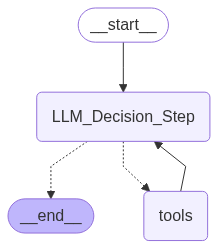

In [105]:
agent.agent_graph

('Let’s get started with your Kyoto adventure! I’ll first check the current '
 'weather and a 5‑day forecast for Kyoto, then look into top attractions, '
 'local dining options (keeping in mind your preference for local food), and '
 'public transportation options. We’ll also explore hotel options that fit '
 'your budget (around $70 per night) and convert that amount to Japanese Yen. '
 'Finally, I’ll estimate an overall cost for your 5‑day trip (including hotel, '
 'food, and activities) and compile a detailed daily plan.\n'
 '\n'
 'Let me begin by checking the current weather and forecast for Kyoto. One '
 'moment…')
